# Group 3 Final Term Notebook

Members: Chen Gege, Lynette Cheryl Luth, Tammie Koh, Subhadhra Manikandan, Liu Yichuan, Li Xingqi

In [1]:
# repo imports
import importlib
import os, logging
import pandas as pd
import matplotlib.pyplot as plt

# Import and reload modules in dependency order to pick up any changes
import signal_generator
import risk_manager
import main

importlib.reload(signal_generator)
importlib.reload(risk_manager)
importlib.reload(main)

from main import run_backtest, plot_exposure, plot_drawdown, plot_vs_benchmark


## 1. Strategy Description

1. Describe overall strategy - core concepts, enhanced features, trading logic
2. Describe parameters - hyperparameters (to be optimised), execution and risk controls, vol and position sizing

## 2. Backtesting (Out-of-sample testing)

1. Explain why we used out-of-sample testing vs in-sample testing or expanding-window testing
2. Explain the train_frac 

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] Train period: 2012-05-18 00:00:00 → 2016-03-10 00:00:00 (958 days)
[NOTIFY] Test  period: 2016-03-11 00:00:00 → 2019-12-30 00:00:00 (958 days)
[NOTIFY] Saved OOS returns → /Users/chengege/Downloads/is4226-final copy 2/storage/returns_oos.csv
[NOTIFY] Saved OOS trades  → /Users/chengege/Downloads/is4226-final copy 2/storage/trades_oos.csv
{'CAGR': 0.9515975291615033, 'Sharpe': np.float64(6.88753010524299), 'MaxDrawdown': -0.08014186360564557, 'Calmar': 11.873913162838758}


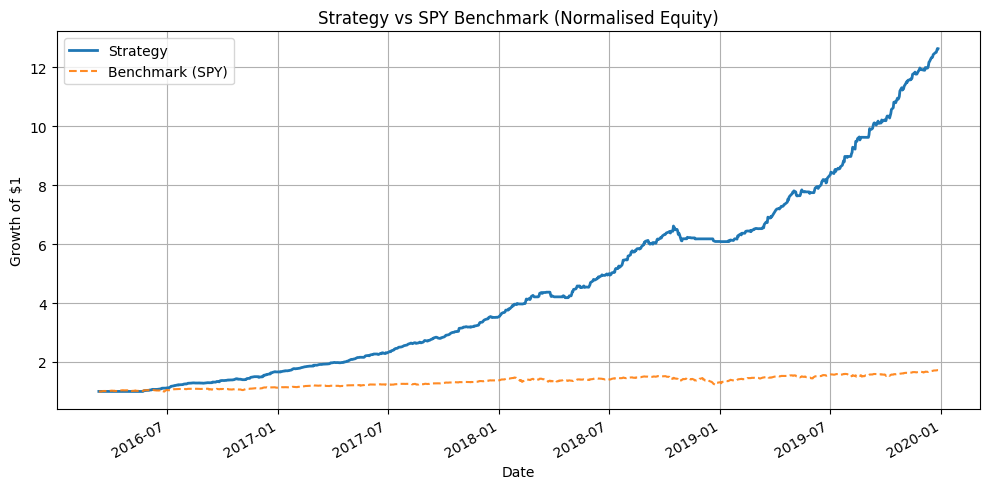

Gross cap respected (sum|weights| ≤ gross_cap).


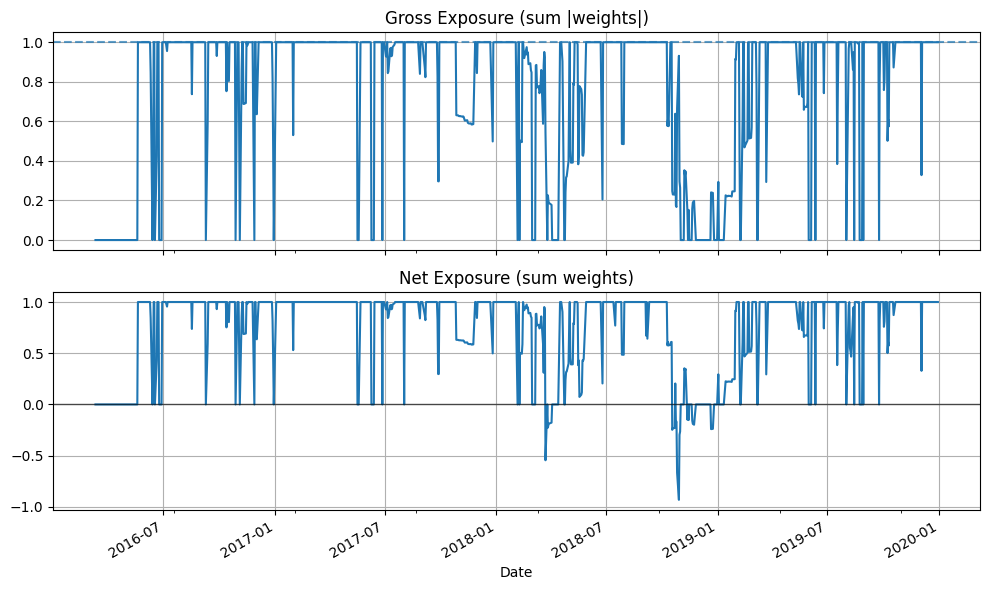

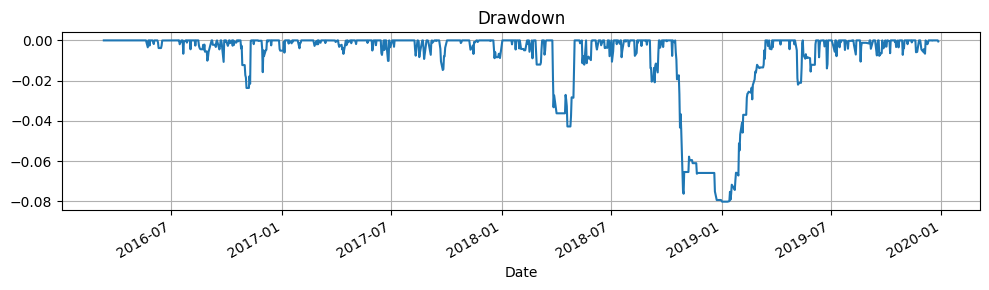


--- Summary ---
Strategy CAGR: 95.16%
Benchmark CAGR: 15.40%
Outperformance: 79.76% per year


In [2]:
start_date = "2010-01-01"
end_date   = "2019-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]
train_frac = 0.5

MA_WINDOW = 100
TRAIL_WINDOW = 8
TRAIL_PCT = 0.91
SHORT_THRESHOLD = 0.01
ATR_WIN = 14

BEAR_LOOKBACK = 20
BEAR_SHORT_THRESHOLD = 0.01

COOLDOWN = 2
EPS = 0.005
MIN_HOLD = 3
K_ATR = 3
GIVEBACK = 1.5
TIME_STOP = 75

TARGET_VOL = 0.1
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 50

VOL_SCALING = True 
VOL_SCALING_THRESHOLD = 1.7
VOL_SCALING_MIN = 0.4

# --- Run the backtest ---
results = run_backtest(
    start_date=start_date, end_date=end_date, stock_list=stock_list, train_frac=train_frac,
    ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
    short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
    cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD,
    k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
    target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
    initial_capital=500_000.0, compare_spy=True, tag="final"
)

print(results["portfolio_metrics"])

plot_vs_benchmark(results); plot_exposure(results); plot_drawdown(results)

print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

## 3. Strategy Optimisation

1. Describe key performance metrics & why we decided to use them
2. Describe how the strategy was optimised based on these metrics / what we improved on from mid-term

In [3]:
import itertools
import numpy as np

# Same setup as backtesting cell
start_date = "2010-01-01"
end_date   = "2019-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]
train_frac = 0.5

# Fixed parameters (same as backtesting cell - these won't be optimized)
ATR_WIN = 14
EPS = 0.005
GROSS_CAP = 1.0
ROLL_VOL = 20
VOL_SCALING = True

# Define parameters to search (only parameters that vary)
param_grid = {
    'ma_window': [100, 130, 150],
    'trailing_window': [8, 10, 12],
    'trailing_pct': [0.91, 0.93, 0.95],
    'short_threshold': [0.01, 0.02, 0.03],
    'bear_lookback': [15, 20, 25],
    'bear_short_threshold': [0.005, 0.01, 0.015],
    'cooldown_bars': [2, 3, 4],
    'min_hold': [3, 5, 7],
    'k_atr_stop': [2.0, 2.5, 3.0],
    'giveback_atr': [1.5, 2.0, 2.5],
    'time_stop': [45, 60, 75],
    'target_vol': [0.08, 0.10, 0.12],
    'perf_lookback': [50, 63, 75],
    'vol_scaling_threshold': [1.3, 1.5, 1.7],
    'vol_scaling_min': [0.2, 0.3, 0.4],
}

# Generate combinations 
n_trials = 100  
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
combinations = [tuple(np.random.choice(vals) for vals in param_values) for _ in range(n_trials)]

print(f"Testing {n_trials} parameter combinations...\n")
optimization_results = []  # Changed name to avoid conflict with 'results' variable

for combo in combinations:
    # Extract parameter values from combination
    MA_WINDOW = combo[param_names.index('ma_window')]
    TRAIL_WINDOW = combo[param_names.index('trailing_window')]
    TRAIL_PCT = combo[param_names.index('trailing_pct')]
    SHORT_THRESHOLD = combo[param_names.index('short_threshold')]
    BEAR_LOOKBACK = combo[param_names.index('bear_lookback')]
    BEAR_SHORT_THRESHOLD = combo[param_names.index('bear_short_threshold')]
    COOLDOWN = combo[param_names.index('cooldown_bars')]
    MIN_HOLD = combo[param_names.index('min_hold')]
    K_ATR = combo[param_names.index('k_atr_stop')]
    GIVEBACK = combo[param_names.index('giveback_atr')]
    TIME_STOP = combo[param_names.index('time_stop')]
    TARGET_VOL = combo[param_names.index('target_vol')]
    PERF_LOOKBACK = combo[param_names.index('perf_lookback')]
    VOL_SCALING_THRESHOLD = combo[param_names.index('vol_scaling_threshold')]
    VOL_SCALING_MIN = combo[param_names.index('vol_scaling_min')]
    
    try:
        # Run backtest with EXACT same structure as backtesting cell
        result = run_backtest(
            start_date=start_date, end_date=end_date, stock_list=stock_list, train_frac=train_frac,
            ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
            short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
            bear_lookback=BEAR_LOOKBACK, bear_short_threshold=BEAR_SHORT_THRESHOLD,
            cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD,
            k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
            target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
            vol_scaling=VOL_SCALING, vol_scaling_threshold=VOL_SCALING_THRESHOLD, vol_scaling_min=VOL_SCALING_MIN,
            initial_capital=500_000.0, compare_spy=True, tag="search"
        )
        metrics = result['portfolio_metrics']  # Fixed: changed from 'optimized_metrics' to 'portfolio_metrics'
        optimization_results.append({
            **{name: val for name, val in zip(param_names, combo)},
            'CAGR': metrics['CAGR'],
            'Sharpe': metrics['Sharpe'],
            'MaxDrawdown': metrics['MaxDrawdown'],
            'Calmar': metrics['Calmar'],
        })
    except Exception as e:
        print(f"Error with combination: {e}")
        continue

# Sort by CAGR and print top results
if len(optimization_results) > 0:
    results_df = pd.DataFrame(optimization_results).sort_values('CAGR', ascending=False)
    print("="*80)
    print(f"TOP {min(10, len(results_df))} PARAMETER COMBINATIONS (by CAGR)")
    print("="*80)
    for i, (idx, row) in enumerate(results_df.head(10).iterrows(), 1):
        print(f"\n#{i} - CAGR: {row['CAGR']:.2%} | Sharpe: {row['Sharpe']:.2f} | MaxDD: {row['MaxDrawdown']:.2%} | Calmar: {row['Calmar']:.2f}")
        for param in param_names:
            print(f"   {param}: {row[param]}")
else:
    print("No successful optimization results. Visualization cells will use results from Cell 4.")

Testing 100 parameter combinations...

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] Train period: 2012-05-18 00:00:00 → 2016-03-10 00:00:00 (958 days)
[NOTIFY] Test  period: 2016-03-11 00:00:00 → 2019-12-30 00:00:00 (958 days)
[NOTIFY] Saved OOS returns → /Users/chengege/Downloads/is4226-final copy 2/storage/returns_oos.csv
[NOTIFY] Saved OOS trades  → /Users/chengege/Downloads/is4226-final copy 2/storage/trades_oos.csv
[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] Train period: 2012-05-18 00:00:00 → 2016-03-10 00:00:00 (958 days)
[NOTIFY] Test  period: 2016-03-11 00:00:00 → 2019-12-30 00:00:00 (958 days)
[NOTIFY] Saved OOS returns → /Users/chengege/Downloads/is4226-final copy 2/storage/returns_oos.csv
[NOTIFY] Saved OOS trades  → /Users/chengege/Downloads/is4226-final copy 2/storage/trades_oos.csv
[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG,

## 4. Strategy Visualisation & Evaluation

Evaluate how the final optimised strategy performs, with the help of various visualisations.

### 4.1 Performance Metrics

In [4]:
print(results["portfolio_metrics"])

{'CAGR': 0.9515975291615033, 'Sharpe': np.float64(6.88753010524299), 'MaxDrawdown': -0.08014186360564557, 'Calmar': 11.873913162838758}


### 4.2 Performance vs Benchmark

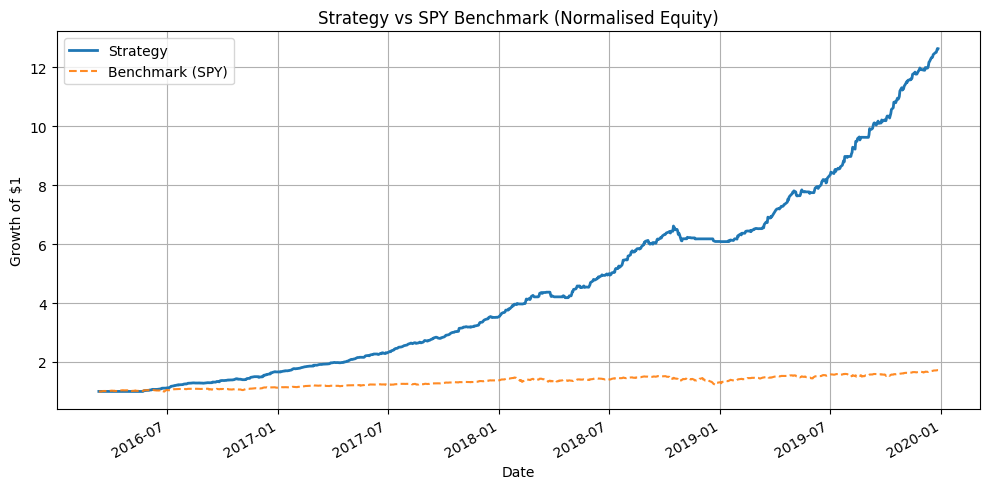

In [5]:
plot_vs_benchmark(results)

### 4.3 Portfolio Exposure

Gross cap respected (sum|weights| ≤ gross_cap).


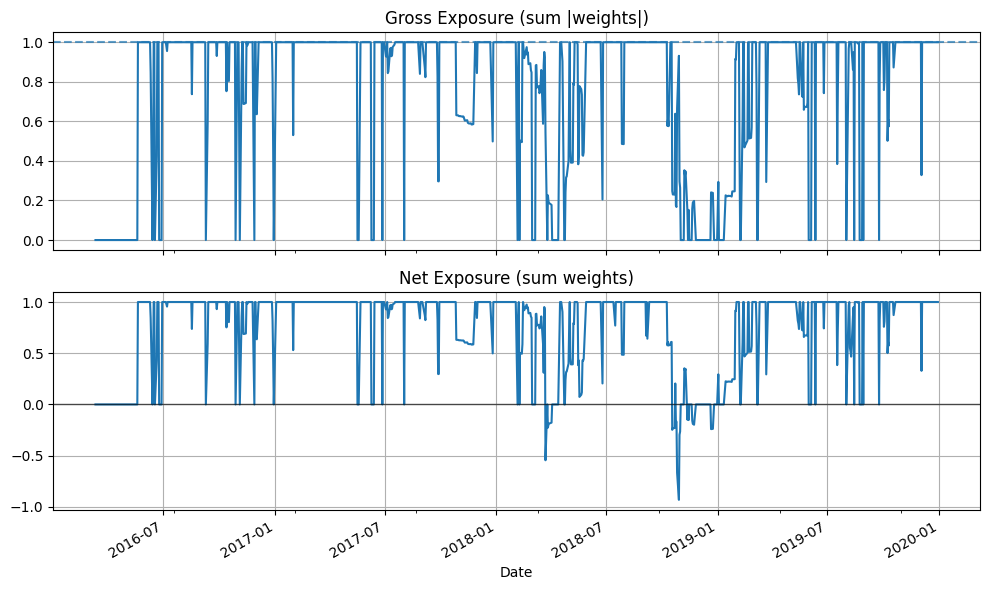

In [6]:
plot_exposure(results)

### 4.4 Portfolio Drawdown

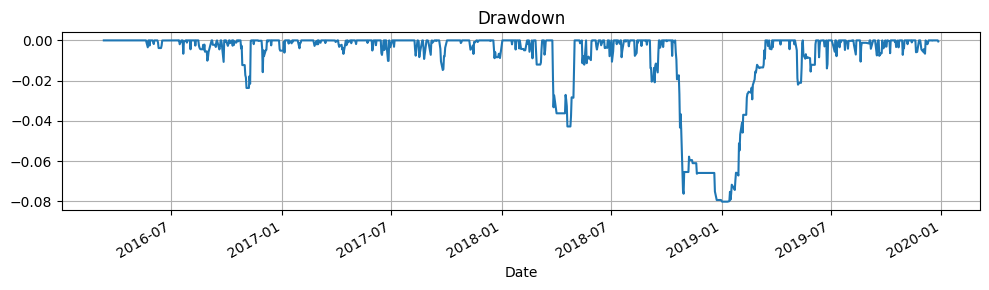

In [7]:
plot_drawdown(results)

### 4.5 Summary

In [8]:
print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

# minimal logging (saved to /storage/logs/)
log_dir = "./storage/logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "run_backtest.log"),
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logging.info(
    f"Backtest completed | Period: {start_date} → {end_date} | "
    f"Universe: {stock_list} | Metrics: {results['portfolio_metrics']}"
)
print("Logged to storage/logs/run_backtest.log")


--- Summary ---
Strategy CAGR: 95.16%
Benchmark CAGR: 15.40%
Outperformance: 79.76% per year
Logged to storage/logs/run_backtest.log


## 5. Final Notebook Cell (Graders edit here)

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] Train period: 2020-01-02 00:00:00 → 2022-10-17 00:00:00 (704 days)
[NOTIFY] Test  period: 2022-10-18 00:00:00 → 2023-12-29 00:00:00 (302 days)
[NOTIFY] Saved OOS returns → /Users/chengege/Downloads/is4226-final copy 2/storage/returns_oos.csv
[NOTIFY] Saved OOS trades  → /Users/chengege/Downloads/is4226-final copy 2/storage/trades_oos.csv
{'CAGR': 1.2933345701625476, 'Sharpe': np.float64(6.650402577001788), 'MaxDrawdown': -0.019889378884650366, 'Calmar': 65.02639311480354}


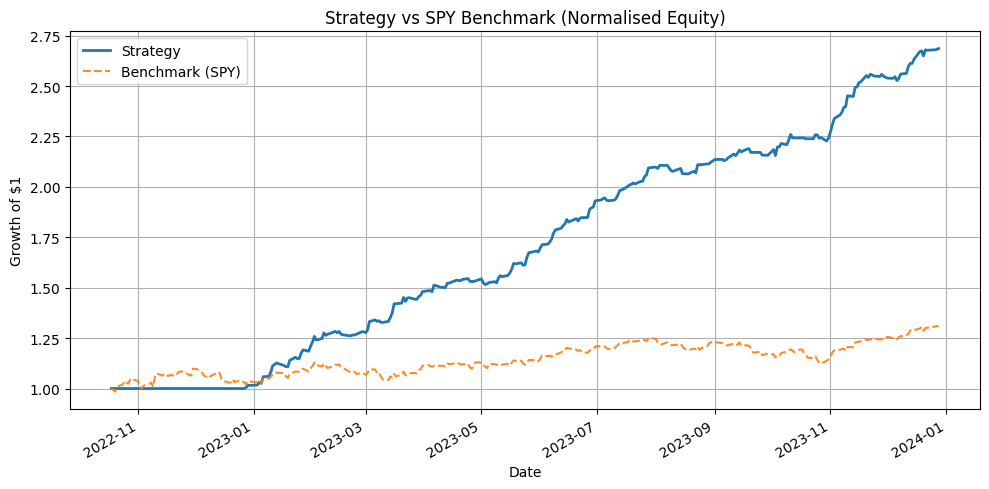

Gross cap respected (sum|weights| ≤ gross_cap).


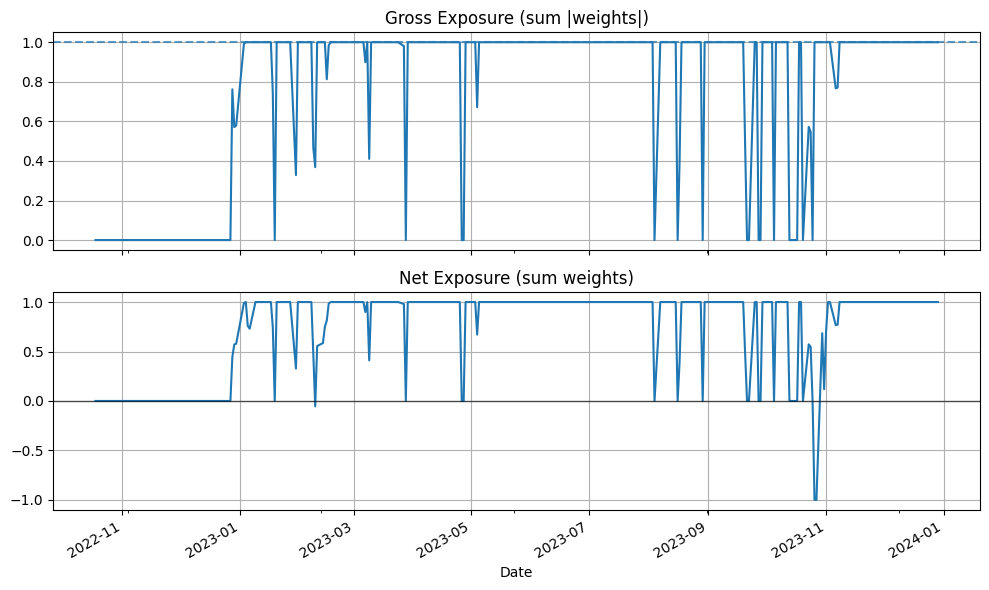

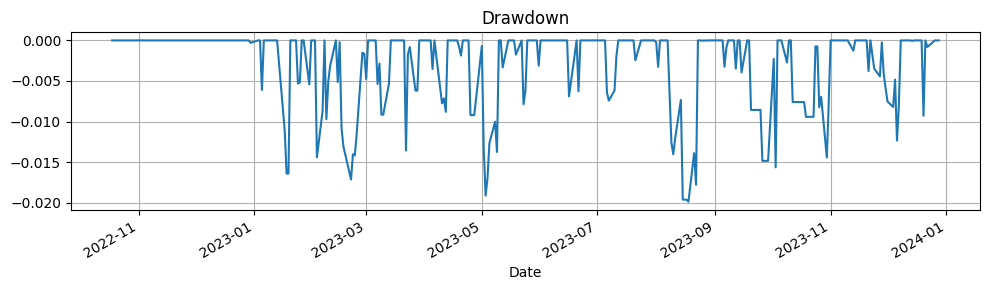


--- Summary ---
Strategy CAGR: 129.33%
Benchmark CAGR: 25.46%
Outperformance: 103.88% per year
Logged to storage/logs/run_backtest.log


In [9]:
start_date = "2020-01-01"
end_date   = "2023-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]
train_frac = 0.7

MA_WINDOW = 100
TRAIL_WINDOW = 8
TRAIL_PCT = 0.91
SHORT_THRESHOLD = 0.01
ATR_WIN = 14

BEAR_LOOKBACK = 20
BEAR_SHORT_THRESHOLD = 0.01

COOLDOWN = 2
EPS = 0.005
MIN_HOLD = 3
K_ATR = 3
GIVEBACK = 1.5
TIME_STOP = 75

TARGET_VOL = 0.1
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 50

VOL_SCALING = True 
VOL_SCALING_THRESHOLD = 1.7
VOL_SCALING_MIN = 0.4

# --- Run the backtest ---
results = run_backtest(
    start_date=start_date, end_date=end_date, stock_list=stock_list,
    ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
    short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
    bear_lookback=BEAR_LOOKBACK, bear_short_threshold=BEAR_SHORT_THRESHOLD,
    cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD,
    k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
    target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
    vol_scaling=VOL_SCALING, vol_scaling_threshold=VOL_SCALING_THRESHOLD, vol_scaling_min=VOL_SCALING_MIN,
    initial_capital=500_000.0, compare_spy=True, tag="final"
)

print(results["portfolio_metrics"])

plot_vs_benchmark(results); plot_exposure(results); plot_drawdown(results)

print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

# minimal logging (saved to /storage/logs/)
log_dir = "./storage/logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "run_backtest.log"),
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logging.info(
    f"Backtest completed | Period: {start_date} → {end_date} | "
    f"Universe: {stock_list} | Metrics: {results['portfolio_metrics']}"
)
print("Logged to storage/logs/run_backtest.log")
